### CS 268 - HW2
* Name: Berkay Guler
* Department: NetSys 

## Problem 1)
### A - Algorithm:
I am implementing DFP method. This method follows the steps below for optimizing a function $f(x)$ where $x \in R^m$.

1) Initialize $Q$, the approximation of the inverse of the hessian of $f$, as the identity matrix. $$Q=I_m$$
2) Perform a line search along the direction $-Q^{(k)}g^{(k)}$ where k is the iterate number and initially $k=1$.
$$\alpha^{(k)}= \underset{\alpha}{argmin} f(x^{(k)}-\alpha Q^{(k)}g^{(k)})$$
3) Perform descent.
$$ x^{(k+1)} = x^{(k)}-\alpha^{(k)} Q^{(k)}g^{(k)}$$
4) Update $Q$ for the next descent using DFP formualation.
$$Q^{(k+1)} = Q^{(k)} + \frac{\delta^{(k+1)} \delta^{(k+1)^{T}}}{\delta^{(k+1)^{T}} \gamma^{(k+1)}} - \frac{Q^{(k)} \gamma^{(k+1)} \gamma^{(k+1)^{T}} Q^{(k)}}{\gamma^{(k+1)^{T}} Q^{(k)} \gamma^{(k+1)}}$$
5) Repeat steps 2, 3 and 4 until convergence.

In [1]:
using LinearAlgebra

abstract type DescentMethod end

mutable struct DFP <: DescentMethod
    Q
end

function init!(M::DFP, f, ∇f, x)
    # source code taken from: K&W Algorithms for Optimization page 93
    m = length(x)
    M.Q = Matrix(1.0I, m, m)
    return M
end

function step!(M::DFP, f, ∇f, x)
    # source code taken (but modified) from: K&W Algorithms for Optimization page 93
    Q, g = M.Q, ∇f(x)
    α = line_search(f, x, -Q*g)
    x′ = x - α*Q*g
    g′ = ∇f(x′)
    δ = x′ - x
    γ = g′ - g
    Q[:] = Q - Q*γ*γ'*Q/(γ'*Q*γ) + δ*δ'/(δ'*γ)
    return x′
end

function line_search(f, x, d)
    # source code taken (but modified) from: K&W Algorithms for Optimization page 54
    # returns optimal step size by performing line search of f along d and starting at x
    objective = α -> f(x + α*d)
    # 1-D minimization solver 
    α = minimize(objective)
    return α
end

function minimize(
        func, initial_point=0, 
        initial_step_size=1e-2, convergence_thr=0.000000001;)
    # source code taken (but modified) from: K&W Algorithms for Optimization page 41
    # returns the value at which func attains its min value
    # optimization method used = Golden Section Search 
    # source(s) of code used = K&W Algorithms for Optimization, page 41
    
    a, b = bracket_minimum(func, initial_point, s=initial_step_size, k=2.0)
    ρ = φ - 1
    d = ρ * b  + (1 - ρ)*a
    yd = func(d)
    x_estimate_curr = (a + b)/2
    x_estimate_prev = x_estimate_curr + convergence_thr + 0.0001  
    eval_count = 1
    
    while abs(x_estimate_curr - x_estimate_prev) > convergence_thr
        c = ρ*a + (1 - ρ)*b 
        yc = func(c)
        if yc < yd
            b, d, yd = d, c, yc
        else
            a, b = b, c
        end
        x_estimate_prev = x_estimate_curr
        x_estimate_curr = (a + b)/2
        eval_count += 1
    end
    # return x_estimate_curr, abs(x_estimate_curr - x_estimate_prev), eval_count
    return x_estimate_curr
end

function bracket_minimum(fnc, x=0; s=1e-4, k=2.0)
    # source code taken from: K&W Algorithms for Optimization page 36
    # returns an interval in which fnc has a minimum
    # source(s) of code used = K&W Algorithms for Optimization, page 36
    a, ya = x, fnc(x)
    b, yb = a + s, fnc(a + s) 
    if yb > ya
        a, b = b, a
        ya, yb = yb, ya
        s = -s
    end
    while true
        c, yc = b + s, fnc(b + s) 
        if yc > yb
            return a < c ? (a, c) : (c, a)
        end
        a, ya, b, yb = b, yb, c, yc
        s *= k
    end
end

bracket_minimum (generic function with 2 methods)

### B - Defining Test Functions and Their Derivatives:
* The quadratic and non-quadratic test functions for this assignment are polynomials and their gradient can be analythically computed.
* Using the approach employed for Rosenbrock's Function, I have created a 10-D function using summations of Booth's Functions. I also cross checked my gradient functions using ForwardDiff package.

1) 10-D Booth's Function:
$$ f(x) = \sum_{i=1}^{9} {[(x_i + 2x_{i+1}-7)^2 + (2x_i + x_{i+1}-5)^2]}$$
**Note:** Since I do not know the exact analythical solution for the minimum of the 10D Booth's Function, I am using the Optim Julia package to cross check if my DFP implementation finds the correct minimum. This also prevents absolute error metric from being precise for this function. 
2) 10-D Rosenbrock Function:
$$ f(x) = \sum_{i=1}^{9} {[(a-x_i)^2+b(x_{i+1}-x_i^2)^2]}$$
For $a=1$, Rosenbrock Function takes its minimum value
$f(x^*) = 0$ at $x ^* = \{x_i = 1| i=1,2,...,10\}$ 

In [2]:
# 10-D Rosenbrock Test Function
function rosenbrock_10D(x, a=1, b=1)
    # source code taken from HW2X[edge.dst]
    summation = 0
    for i in 1:9
        summation += ((a - x[i])^2 + b*(x[i+1]-x[i]^2)^2)
    end
    return summation
end

# rosenbrock gradient function 
function ∇rosenbrock_10D(x, a=1, b=1)
    # source code taken from HW2
    gradient_vector = []
    
    for i in 1:10
        if i == 1
            df_di = (-2*(a-x[1]) + 2*b*(x[2]-x[1]^2)*-2*x[1])
        elseif i == 10
            df_di = 2*b*(x[10]-x[9]^2)
        else
            df_di = (-2*(a-x[i]) + 2*b*(x[i+1]-x[i]^2)*-2*x[i]) + 2*b*(x[i]-x[i-1]^2) 
        end
        append!(gradient_vector, df_di)
    end
    return gradient_vector
end

# quadractic function
function booths_10D(x)
    # source code taken from HW2
    summation = 0
    for i in 1:9
        summation += ((x[i] + 2*x[i+1] - 7)^2 + (2*x[i] + x[i+1] - 5)^2)
    end
    return summation
end

# gradient of quadratic test function
function ∇booths_10D(x)
    # source code taken from HW2
    gradient_vector = []
    
    for i in 1:10
        if i == 1
            df_di = 2*(x[1]+2*x[2]-7) + 4*(2*x[1] + x[2] - 5)
        elseif i == 10
            df_di = 4*(x[9] + 2*x[10] - 7) + 2*(2*x[9] + x[10] - 5) 
        else
            df_di = 2*(x[i]+2*x[i+1]-7) +
                4*(2*x[i] + x[i+1] - 5) +
                4*(x[i-1] + 2*x[i] - 7) +
                2*(2*x[i-1] + x[i] - 5) 
        end
        append!(gradient_vector, df_di)
    end
    return gradient_vector
end

∇booths_10D (generic function with 1 method)

In [3]:
# verifying gradients
# source code taken from HW2
using ForwardDiff
x = [i/5 for i in 1:10]
gradient_manual = ∇rosenbrock_10D(x)
gradient_auto = ForwardDiff.gradient(rosenbrock_10D, x)
# make sure the gradient function works fine
@assert sum((gradient_manual - gradient_auto).^2) < 1e-10
gradient_manual = ∇booths_10D(x)
gradient_auto = ForwardDiff.gradient(booths_10D, x)
# make sure the gradient function works fine
@assert sum((gradient_manual - gradient_auto).^2) < 1e-10

### C - DFP Loop and Generating Test Points:
* The DFP method runs until the convergence criteria are met. Absolute improvement, gradient norm (L-2) and maximum descent number are used as stopping criteria.
* The DFP method is tested with 100 starting points. Absolute error, number of descents, last value of the convergence measure, and the elapsed time are reported with mean and standard deviation. 100 test points are selected based on the formula from HW1. Each test point $x=(x_1, x_2, ..., x_{10})$ is selected as follows.
$$Y_i∼Uniform(-a,a)$$ $$X_i = \pm e^{Y_i}$$

In [4]:
using Base.MathConstants


function DFP_descent(M, f, ∇f, x)
    # initialize and descent once
    # source code taken from HW2 (modified)
    M = init!(M, f, ∇f, x)
    x_current = x
    x_next = step!(M, f, ∇f, x_current)
    descent_count = 1
    # loop until convergence criteria met
    # println(f(x_next) - f(x_current))
    # println(norm(∇f(x_next)))
    # println(descent_count)
    while abs(f(x_next) - f(x_current)) > 0.00000001 && norm(∇f(x_next)) > 0.00000001 && descent_count < 10000000 
        x_current = x_next
        x_next = step!(M, f, ∇f, x_current)
        descent_count += 1
    end
    return x_next, descent_count, abs(f(x_next) - f(x_current))
end

function sample_exp_uniform_ndim(num_samples=100, ndim=10, range=10)
    # source code taken from HW2
    # returns N-D test points
    columns = []
    for i in 1:ndim
        # sample num_samples numbers from [-range, range]
        x = range*(rand(num_samples)) .* rand((-1, 1), num_samples)
        # raise to the power of e and select a random sign
        y = e.^x .* rand((-1, 1), 100)
        append!(columns, [y])
    end
    return hcat(columns...)
end

sample_exp_uniform_ndim (generic function with 4 methods)

### D - Reportig Statistics:

In [16]:
# source code taken from HW2 (modified)
using Optim
using Statistics
using TypedTables

a = 10  # sampling range for uniform dist.
# rosenbrock
rb_samples = sample_exp_uniform_ndim(100, 10, a)
rb_gt_min_x = [1 for i in 1:10]
rb_gt_min_f = rosenbrock_10D(rb_gt_min_x)

# quadratic
bt_samples = sample_exp_uniform_ndim(100, 10, a)
# solve for optimal value using Optim package
bt_res = optimize(booths_10D, bt_samples[1,:], LBFGS())
bt_gt_min_x = Optim.minimizer(bt_res)
bt_gt_min_f = booths_10D(bt_gt_min_x)

zip_object = zip(
    (rb_samples, bt_samples), 
    (rb_gt_min_f, bt_gt_min_f),
    (rosenbrock_10D, booths_10D),
    (∇rosenbrock_10D, ∇booths_10D)
)

mean_error_col = []
mean_desc_count_col = []
mean_conv_measure_col = []
mean_elapsed_time_col = []
std_error_col = []
std_desc_count_col = []
std_conv_measure_col = []
std_elapsed_time_col = []

for (samples, gt_min_f, f, ∇f) in zip_object  
    
    absolute_error_arr = []
    descent_count_arr = []
    convergence_measure_arr = []
    elapsed_time_arr = []
    
    for i in 1:size(samples)[1]
        tic = time()
        M = DFP(nothing)  # initial α value does not matter
        min_x, num_descent, conv_measure = DFP_descent(
            M, f, ∇f, samples[i,:]
        )
        elapsed_time = (time() - tic) * 1000
        min_f = f(min_x)
        append!(absolute_error_arr, abs(min_f - gt_min_f))
        append!(descent_count_arr, num_descent)
        append!(convergence_measure_arr, conv_measure)
        append!(elapsed_time_arr, elapsed_time)
    end
    
    append!(mean_error_col, mean(absolute_error_arr))
    append!(mean_desc_count_col, mean(descent_count_arr))
    append!(mean_conv_measure_col, mean(convergence_measure_arr))
    append!(mean_elapsed_time_col, mean(elapsed_time_arr))
    append!(std_error_col, std(absolute_error_arr))
    append!(std_desc_count_col, std(descent_count_arr))
    append!(std_conv_measure_col, std(convergence_measure_arr))
    append!(std_elapsed_time_col, std(elapsed_time_arr))
end

### D.1 - Mean Table:

In [17]:
mean_table = Table(
    Func = ["10-D Rosenbrock", "10-D Booth's Function"], 
    AbsoluteError = mean_error_col,
    Convergence = mean_conv_measure_col, NumDescents = mean_desc_count_col,
    TimeMilisecs = mean_elapsed_time_col)

Table with 5 columns and 2 rows:
     Func                  AbsoluteError  Convergence  NumDescents  TimeMilisecs
   ┌────────────────────────────────────────────────────────────────────────────
 1 │ 10-D Rosenbrock       4.90758e-11    2.11186e-9   381.79       25.2741
 2 │ 10-D Booth's Functi…  4.79616e-15    1.98804e-9   11.27        0.478354

### D.2 - Standard Variation Table:

In [18]:
std_table = Table(
    Func = ["10-D Rosenbrock", "10-D Booth's Function"], 
    AbsoluteError = std_error_col,
    Convergence = std_conv_measure_col, NumDescents = std_desc_count_col,
    TimeMilisecs = std_elapsed_time_col)

Table with 5 columns and 2 rows:
     Func                  AbsoluteError  Convergence  NumDescents  TimeMilisecs
   ┌────────────────────────────────────────────────────────────────────────────
 1 │ 10-D Rosenbrock       1.66291e-10    2.64089e-9   698.24       50.0912
 2 │ 10-D Booth's Functi…  1.96505e-14    6.3921e-9    0.446196     0.408424

## Problem 2)

### A - Problem Formulation

I have a bachelor's degree in Electrical Engineering, which makes me tempted to investigate the resistance network in 2D grid graph structure. 

$G(V, E)$ is directed graph of size $m$x$n$ where each node $x_i$ denotes the voltage value and $C_{ij}$ denotes the conductance between node $x_i$ and $x_j$ if $(i,j)\in E$. Assuming there is a current flowing from $x_i$ to $x_j$ when $x_i > x_j$, the total dissipated power can be formulated as:
$$ P(x) = \sum_{(i,j)\in E} {g(x_i, x_j)} = \sum_{(i,j)\in E} C_{ij}(x_i-x_j)^2$$
The gradient vector $\nabla P=\{ \frac{\partial P}{\partial x_i}|i=1,2,...,mn \}$ where
$$ \frac{\partial P}{\partial x_k} = \sum_ {(k,j \in E)} {2C_{kj}(x_k-x_j)} - \sum_ {(i,k \in E)} {2C_{ik}(x_i-x_k)}$$
Power dissipation minimizing solution is given by
$$ x_i^* = \frac {\sum_{(i,j) \in E} {C_{ij} x_j} + \sum_{(j,i) \in E} {C_{ij} x_j}} {\sum_{(i,k) \in E} {C_{ik}} + \sum_{(k,i) \in E} {C_{ik}}}$$
However, above solution only gives a system of equations which requires other optimization techniques to solve. Hence, I am only validationg my result using the above formula after finding the minimum set of voltages returned by my own DFP implementation.

* $C_{ij}$'s are initialized once such that $\{C_{ij} = e^u | (i,j)\in E\}$ where $u \sim Uniform(-2, 2)$
* 100 different $\{x_i\}_{i=1}^{mn}$ are initialized such that $\{x_{i} = ae^u | i=1,2,...,mn\}$ where $u \sim Uniform(-5, 5)$ and $a \in Uniform(\{-1, 1\})$
* For each set of starting voltages $\{x_i\}_{i=1,2,...,mn}$ two indices and their values are kept unchanged and those vertices have not been updated to prevent the total power from going to zero. I chose those indices as follows $$x_3 = 1$$ and $$x_7 = 2$$

In [19]:
using Graphs

abstract type network end

mutable struct resistor_network <: network
    C  # conductances
    x1_idx  # index at which the voltage is fixed
    x2_idx  # index at which the voltage is fixed
end

function init_network!(net::network, graph::SimpleGraph, a=2)
    # returns resistor network with random conductance on each edge
    net.C = Dict{Any, Any}()
    for edge in edges(graph)
        sign = first(rand([-1, 1], 1))
        net.C[(edge.src, edge.dst)] = e^(sign * a * rand())
    end
    return net
end

function grid_power(g::SimpleGraph, net::network, x)
    # returns dissipated power on a network 
    total_power = 0
    for edge in edges(g)
        x_i = x[edge.src]
        x_j = x[edge.dst]
        total_power += (net.C[(edge.src, edge.dst)]) * (x_i - x_j)^2
    end
    return total_power
end

function ∇grid_power(g::SimpleGraph, net::network, x)
    # returns the gradient of dissipated power on the network
    gradient_vector = []
    for vertex in vertices(g)
        vertex_gradient = 0
        # gradient is set to 0 and not updated for fixed voltage nodes
        if vertex != net.x1_idx && vertex != net.x2_idx 
            for ner in all_neighbors(g, vertex)
                src = min(ner, vertex)
                dst = max(ner, vertex)
                # depending on the current flow direction derivative sign changes
                if x[ner] > x[vertex]
                    vertex_gradient += (-2 * net.C[(src, dst)] * (x[ner]-x[vertex]))
                else
                    vertex_gradient += (2 * net.C[(src, dst)] * (x[vertex]-x[ner]))
                end
            end
        end
        push!(gradient_vector, vertex_gradient)
    end
    return gradient_vector
end

function gt_min_grid_power(g::SimpleGraph, net::network, x)
    # returns the vector x that minimizes total power
    x_star = []
    for vertex in vertices(g)
        if vertex != net.x1_idx && vertex != net.x2_idx     
            weighted_ner_conductance_sum = 0
            ner_conductance_sum = 0
            for ner in all_neighbors(g, vertex)
                src = min(ner, vertex)
                dst = max(ner, vertex)
                current_c = net.C[(src, dst)]
                weighted_ner_conductance_sum += (current_c * x[ner])
                ner_conductance_sum += current_c
            end
            current_x_star = weighted_ner_conductance_sum / ner_conductance_sum 
        else
            current_x_star = x[vertex]
        end
        push!(x_star, current_x_star)
    end
    return x_star
end

gt_min_grid_power (generic function with 1 method)

### B - DFP on Resistor Network
* Since my implementation of power and gradient of the power requires the graph and resistor network as parameters, I needed to slighly change my descent loop, step, and line search functions.

In [20]:
function line_search_graph(f, x, d, graph, network)
    # source code taken (but modified) from: K&W Algorithms for Optimization page 54
    # returns optimal step size by performing line search of f along d and starting at x
    objective = α -> f(graph, network, x + α*d)
    # 1-D minimization solver 
    α = minimize(objective)
    return α
end


function step_graph!(M::DFP, f, ∇f, x, graph, network)
    # source code taken (but modified) from: K&W Algorithms for Optimization page 93
    Q, g = M.Q, ∇f(graph, network, x)
    α = line_search_graph(f, x, -Q*g, graph, network)
    x′ = x - α*Q*g
    g′ = ∇f(graph, network, x′)
    δ = x′ - x
    γ = g′ - g
    Q[:] = Q - Q*γ*γ'*Q/(γ'*Q*γ) + δ*δ'/(δ'*γ)
    return x′
end


function DFP_descent_graph(M, f, ∇f, x, graph, network)
    # initialize and descent once
    # source code taken from HW2 (modified)
    M = init!(M, f, ∇f, x)
    x_current = x
    x_next = step_graph!(M, f, ∇f, x_current, graph, network)
    descent_count = 1
    # loop until convergence criteria met
    while abs(f(graph, network, x_next) - f(graph, network, x_current)) > 0.00000001 && norm(∇f(graph, network, x_next)) > 0.00000001 && descent_count < 10000000 
        x_current = x_next
        x_next = step_graph!(M, f, ∇f, x_current, graph, network)
        descent_count += 1
    end
    return x_next, descent_count, abs(f(graph, network, x_next) - f(graph, network, x_current))
end

DFP_descent_graph (generic function with 1 method)

### C - Verifying the Implementation:

As explained above, I am verifying my implementation by checking whether the minimum I found via DFP satisfies the formula for each node to achieve minimum power. 

To further verify my graph and DFP implementation, I tested my solution on a 2x2 graph where I have two fixed node voltages. Due to the simplicity of the arising total power function, finding the exact minimum analythically is easy. 

Given the fixed node voltages $x_1=1$ and $x_2=2$ and assuming $C_{ij} = 1$ for all $(i,j) \in E$. The total power function is given below 
$$P(x_3, x_4) = (x_3 - x_4)^2 + (x_3 - 1)^2 + (x_4 - 2)^2 + 1$$ which attains its minimum value at $x_{3}^{*}=\frac{4}{3}$ and $x_{4}^{*}=\frac{5}{3}$

In [21]:
using Graphs

# which two vertices to keep constant and their voltages
x1_idx = 1
x2_idx = 2
x1 = 1  # constant voltage
x2 = 2  # constant voltage

# sampling range parameter
a = 5

m = 2
n = 2

gt_min_x = [1, 2, 4/3, 5/3]

# sampling starting voltages
x_samples = sample_exp_uniform_ndim(100, m*n, a)
# set constant voltage indices to given constant voltage values:
x_samples[:, x1_idx] = ones(size(x_samples)[1]) * x1
x_samples[:, x2_idx] = ones(size(x_samples)[1]) * x2 

# init graph
graph = grid([m, n])
net = resistor_network(nothing, x1_idx, x2_idx)
net = init_network!(net, graph)

absolute_error_arr = []
descent_count_arr = []
convergence_measure_arr = []
elapsed_time_arr = []

for i in 1:size(x_samples)[1]
    tic = time()
    M = DFP(nothing)  # initial Q unimportant 
    min_x, num_descent, conv_measure = DFP_descent_graph(
        M, grid_power, ∇grid_power, x_samples[i,:], graph, net
    )
    elapsed_time = (time() - tic) * 1000
    min_power = grid_power(graph, net, min_x)
    gt_min_power = grid_power(graph, net, gt_min_x)
    push!(absolute_error_arr, abs(min_power - gt_min_power))
    push!(descent_count_arr, num_descent)
    push!(convergence_measure_arr, conv_measure)
    push!(elapsed_time_arr, elapsed_time)
end

### C.1 - Mean Table:

In [22]:
mean_table = Table(
    GraphSize = ["2x2 Known Graph"],
    AbsError=[mean(absolute_error_arr)],
    Convergence=[mean(convergence_measure_arr)], NumDescents =[mean(descent_count_arr)],
    TimeMilisecs = [mean(elapsed_time_arr)])

Table with 5 columns and 1 row:
     GraphSize        AbsError  Convergence  NumDescents  TimeMilisecs
   ┌──────────────────────────────────────────────────────────────────
 1 │ 2x2 Known Graph  0.347997  0.0215894    2.97         1.09469

### C.2 - Standard Variation Table:

In [23]:
mean_table = Table(
    GraphSize = ["2x2 Known Graph"],
    AbsError=[std(absolute_error_arr)],
    Convergence=[std(convergence_measure_arr)], NumDescents =[std(descent_count_arr)],
    TimeMilisecs = [std(elapsed_time_arr)])

Table with 5 columns and 1 row:
     GraphSize        AbsError     Convergence  NumDescents  TimeMilisecs
   ┌─────────────────────────────────────────────────────────────────────
 1 │ 2x2 Known Graph  2.19246e-15  0.140676     0.171447     9.6965

### D - Statistics
* To investigate the behavior of the method, I am repeating the same experiment with different graph sizes by both changing the length and width of my grid graph.

In [44]:
using Graphs
mns = [[3,3], [4,4], [5,5], [6,6], [7,7], [8,8], [9,9]]

# which two vertices to keep constant and their voltages
x1_idx = 3
x2_idx = 7
x1 = 1  # constant voltage
x2 = 2  # constant voltage

# sampling range parameter
a = 5

mean_desc_count_col = []
mean_conv_measure_col = []
mean_elapsed_time_col = []
std_desc_count_col = []
std_conv_measure_col = []
std_elapsed_time_col = []

for  (m, n) in mns
    println("Optimizing $m by $n graph")
    # sampling starting voltages
    x_samples = sample_exp_uniform_ndim(100, m*n, a)
    # set constant voltage indices to given constant voltage values:
    x_samples[:, x1_idx] = ones(size(x_samples)[1]) * x1
    x_samples[:, x2_idx] = ones(size(x_samples)[1]) * x2 

    # init graph
    graph = grid([m, n])
    net = resistor_network(nothing, x1_idx, x2_idx)
    net = init_network!(net, graph)
    
    absolute_error_arr = []
    descent_count_arr = []
    convergence_measure_arr = []
    elapsed_time_arr = []
    
    for i in 1:size(x_samples)[1]
        tic = time()
        M = DFP(nothing)  # initial Q unimportant 
        min_x, num_descent, conv_measure = DFP_descent_graph(
            M, grid_power, ∇grid_power, x_samples[i,:], graph, net
        )
        @assert norm(min_x - gt_min_grid_power(graph, net, min_x)) < 0.0001
        elapsed_time = (time() - tic) * 1000
        push!(descent_count_arr, num_descent)
        push!(convergence_measure_arr, conv_measure)
        push!(elapsed_time_arr, elapsed_time)
    end
    append!(mean_desc_count_col, mean(descent_count_arr))
    append!(mean_conv_measure_col, mean(convergence_measure_arr))
    append!(mean_elapsed_time_col, mean(elapsed_time_arr))
    append!(std_desc_count_col, std(descent_count_arr))
    append!(std_conv_measure_col, std(convergence_measure_arr))
    append!(std_elapsed_time_col, std(elapsed_time_arr))
end

Optimizing 3 by 3 graph
Optimizing 4 by 4 graph
Optimizing 5 by 5 graph
Optimizing 6 by 6 graph
Optimizing 7 by 7 graph
Optimizing 8 by 8 graph
Optimizing 9 by 9 graph


### D.1 - Mean Table:

In [45]:
graph_names = ["($i,$i)" for i in 3:9]

mean_table = Table(
    GraphSize = graph_names, 
    Convergence = mean_conv_measure_col, NumDescents = mean_desc_count_col,
    TimeMilisecs = mean_elapsed_time_col)

Table with 4 columns and 7 rows:
     GraphSize  Convergence  NumDescents  TimeMilisecs
   ┌──────────────────────────────────────────────────
 1 │ (3,3)      4.5387e-14   8.0          0.835037
 2 │ (4,4)      5.75684e-14  15.0         2.18216
 3 │ (5,5)      6.30232e-9   23.89        5.79933
 4 │ (6,6)      8.34104e-10  34.76        13.2464
 5 │ (7,7)      2.34485e-9   44.84        26.1737
 6 │ (8,8)      4.75281e-9   55.19        47.8415
 7 │ (9,9)      5.13918e-9   66.12        83.7318

### D.2 - Standard Variation Table:

In [46]:
graph_names = ["($i,$i)" for i in 3:8]

mean_table = Table(
    GraphSize = graph_names, 
    Convergence = std_conv_measure_col, NumDescents = std_desc_count_col,
    TimeMilisecs = std_elapsed_time_col)

Table with 4 columns and 6 rows:
     GraphSize  Convergence  NumDescents  TimeMilisecs
   ┌──────────────────────────────────────────────────
 1 │ (3,3)      1.04999e-13  0.0          1.46875
 2 │ (4,4)      8.35185e-14  0.0          1.35372
 3 │ (5,5)      5.85158e-8   0.314466     1.98223
 4 │ (6,6)      2.04473e-9   0.473969     2.24368
 5 │ (7,7)      2.50983e-9   0.394917     1.94905
 6 │ (8,8)      2.5654e-9    0.630776     2.06732

**Comments:** As shown in plots below, as the graph size increases, the execution time exponentially increases. 

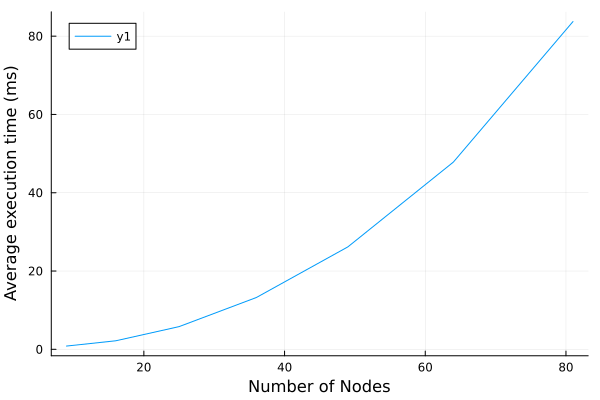

In [49]:
using Plots

graph_size = [m*n for (m,n) in mns]  
plot(graph_size, mean_elapsed_time_col, xlabel="Number of Nodes", ylabel="Average execution time (ms)")

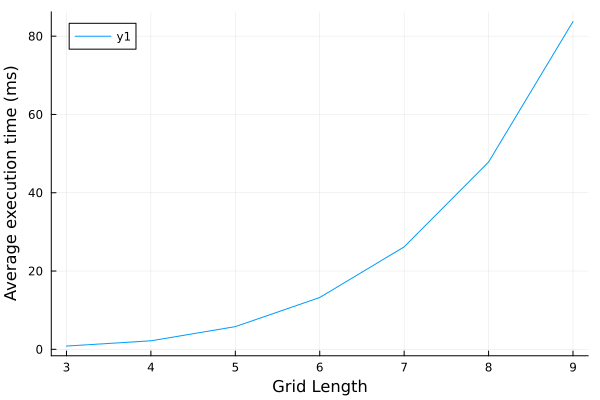

In [50]:
grid_length = [m for (m,n) in mns]  
plot(grid_length, mean_elapsed_time_col, xlabel="Grid Length", ylabel="Average execution time (ms)")